<a href="https://colab.research.google.com/github/BOINISHIVANANDAM/codeinza/blob/master/Project_A4_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 27.40 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [3]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import pandas.util.testing as tm
import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
epochs = 30
batch_size = 150
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 38
seed = random.randint(1, 1000)

data_dir = "/content/PlantVillage-Dataset/data_distribution_for_SVM/train/"
data_dir1 = "/content/PlantVillage-Dataset/data_distribution_for_SVM/test"

In [5]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 7017 images belonging to 38 classes.
Found 2094 images belonging to 38 classes.


/content/PlantVillage-Dataset/data_distribution_for_SVM/train/20/b4d8b32b-6bf4-4b7d-b9fd-73819e1e8c77.JPG


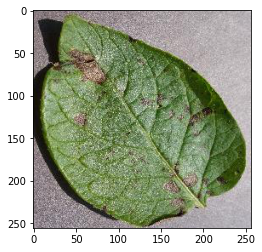

In [6]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [8]:
checkpoint = ModelCheckpoint('dog_breed_classifier.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq=1)

tensorboard =TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq="epoch")
                            #save_freq=0)

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [9]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________

In [10]:
%%time

history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Learning rate:  1e-04
Epoch 1/30
 1/47 [..............................] - ETA: 0s - loss: 4.1742 - accuracy: 0.0200WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
47/47 [==============================] - 122s 3s/step - loss: 1.3081 - accuracy: 0.6724 - val_loss: 2.2857 - val_accuracy: 0.4709
Learning rate:  1e-04
Epoch 2/30
47/47 [==============================] - 119s 3s/step - loss: 0.2378 - accuracy: 0.9391 - val_loss: 1.8580 - val_accuracy: 0.5234
Learning rate:  1e-04
Epoch 3/30
47/47 [==============================] - 119s 3s/step - loss: 0.1158 - accuracy: 0.9711 - val_loss: 1.6124 - val_accuracy: 0.5492
Learning rate:  1e-04
Epoch 4/30
47/47 [==============================] - 1

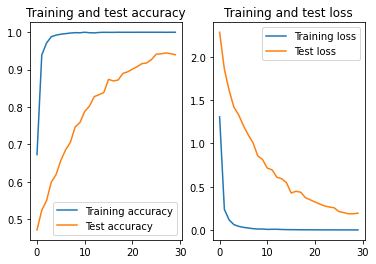

In [11]:
plt.subplot(1, 2, 1)
plt.title('Training and test accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

In [13]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Instructions for updating:
Please use Model.predict, which supports generators.
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        44
          11       0.95      0.95      0.95        44
          12       0.98      0.96      0.97        46
          13       1.00      1.00      1.00        44
          14       0.94      1.00      0.97        15
          15       1.00      1.00      1.00       233
          16       1.00      0.98      0.99        88
          17       0.67      1.00      0.80         4
          18       0.95      0.72      0.82        25
          19       0.92      0.98      0.95        60
           2       1.00      0.92      0.96        12
          20       1.00      1.00      1.00        44
          21       1.00      0.70      0.82        40
          22       0.22      0.67

Confusion Matrix


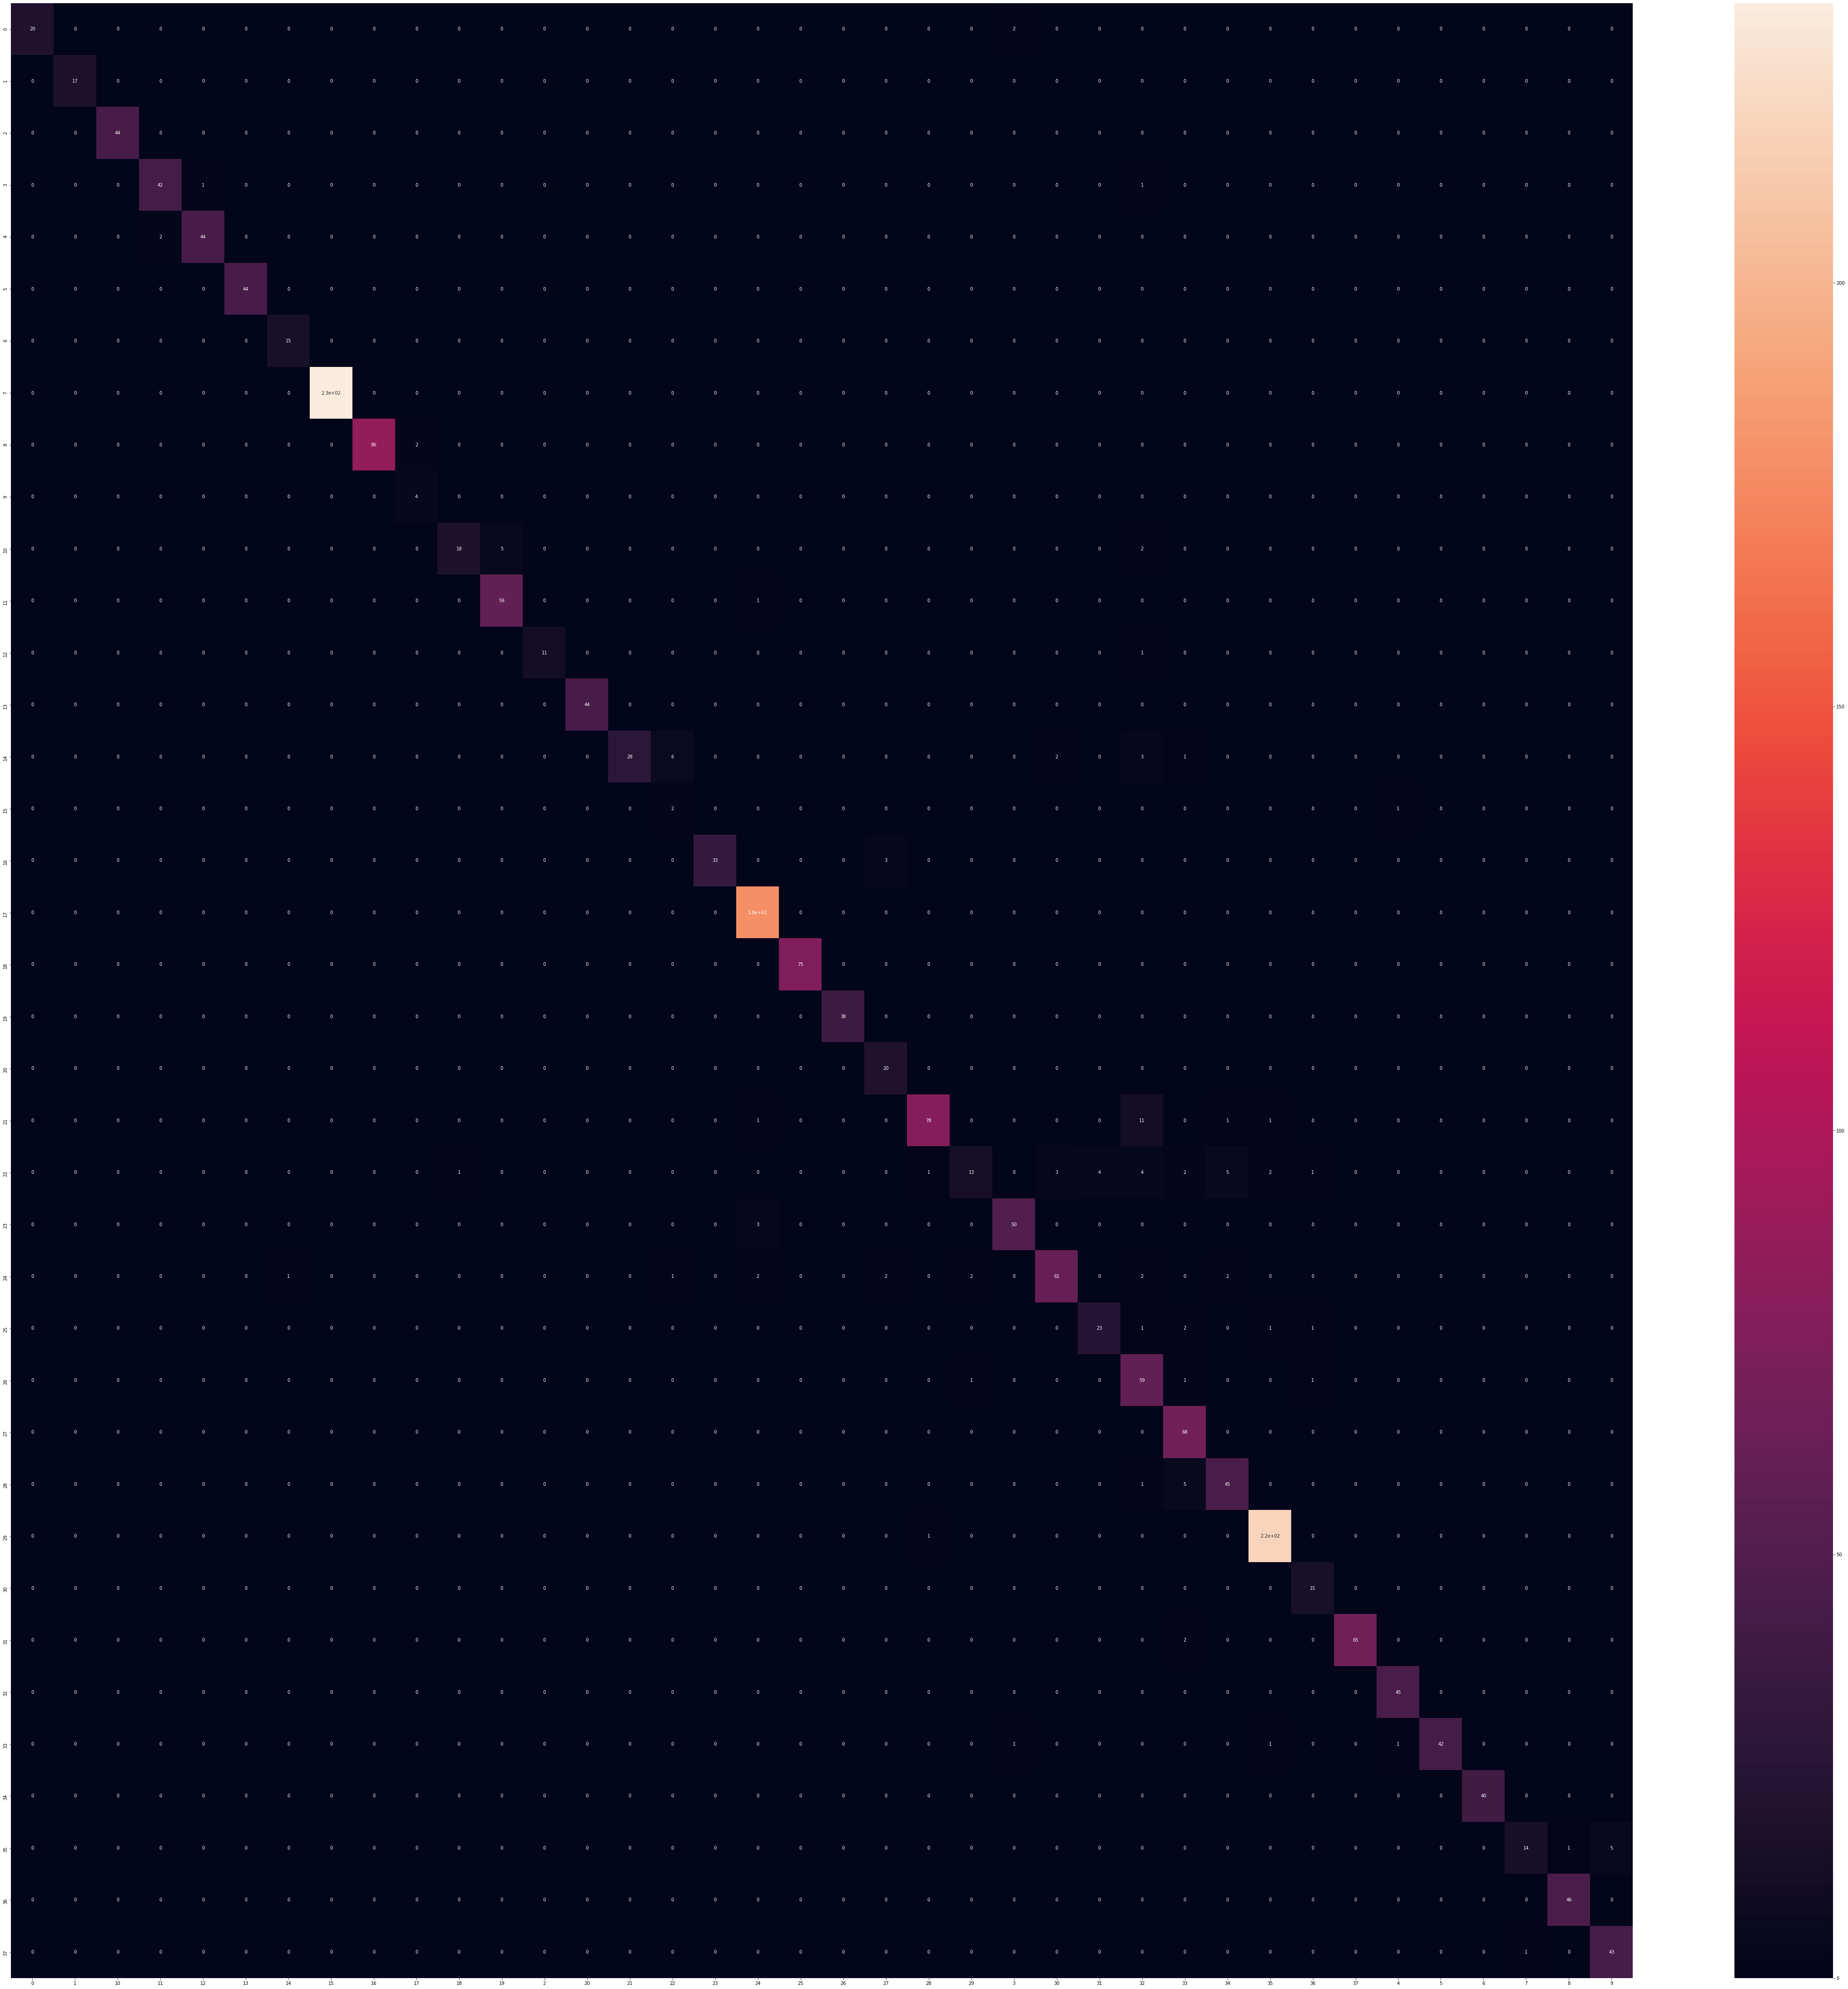

In [14]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y)
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)